## Landmark based registration

**Deadline**: Send this notebook (rename it as 'TP-BIOMED-YOURSURNAME.ipynb') to pietro.gori@telecom-paris.fr before the 4th of November 2020 (23h59). 

**Goal**: This TP is about statistical shape analysis. You will have to answer some theoretical
questions and code some parts of the algorithms using *Python 3*. Please complete the code where you see **XXXXXXXXXXXXXX**

We will use the FEI dataset (https://fei.edu.br/~cet/facedatabase.html) composed of 400 configurations of 68 anatomical landmarks
automatically annotated on frontal face images from both men and women aged between
19 and 40 years old. People express two emotions, either neutral or happy.

You will code the
Procrustes alignment and Generalized Procrustes Analysis (GPA) algorithm to estimate
an average configuration and align all configurations onto it. You will then code Principal
Component Analysis (PCA) to analyze the shape variability.

Please answer questions and code directly in this jupyter notebook.

I strongly suggest that you use google colab (https://colab.research.google.com) but, if you prefer, you can use your own computer. In that case, please use Anaconda 3. You will need the packqges numpy, matplotlib and notebook. If you want to use spyder as IDE, just add `spider` You can create a new environment with the command line: 

`conda create -n BIOMED
python=3.7 numpy matplotlib spyder notebook`

And then

`conda activate BIOMED`

`jupyter-notebook`



First thing to do is to prepare the data...

In [18]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='15vsAdMepHzdoZ3iqNS3kpI3KGW7D0vRs',
  dest_path='./data/Data_FEI.npz')
  gdd.download_file_from_google_drive(file_id='1ywQbf23-JoPklWCcH_mi5Nuw5BQskxvB',
  dest_path='./data/facial_landmarks_68markup.jpg')
  gdd.download_file_from_google_drive(file_id='10OSJUfNDJ1xw6H3sRu7l3LRoojxju_4L',
  dest_path='./data/shape.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./data/" 

... and load the needed libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA


Now, let's load the data. 

We have a list of images, the position of the landmarks (aligned to the images), the class labels Y (0 for neutral and 1 for happy) and the names of the images.

In [3]:
# Loading data

with np.load(Working_directory + 'Data_FEI.npz') as data:
    Images=data['Images_FEI'] # list of images
    Landmarks = data['Landmarks_FEI'] # original landmarks   
    Y = data['Emotions_FEI'] # class, 0 for neutral and 1 for happy
    Names = data['Names_FEI']    
N,M = Landmarks.shape # number subjects 
dim = 2 # we are in 2D
M = int(M/dim) # Number of landmarks (they are in 2D)
print('Number of subjects:', N, '; Number of landmarks:',M) 
class_names = ["neutral","happy"]

## Choose if you want to plot or not the results ##
show_plot =1 # 1 if you want to plot, 0 otherwise

Number of subjects: 400 ; Number of landmarks: 68


Here, we show an example of facial landmarks

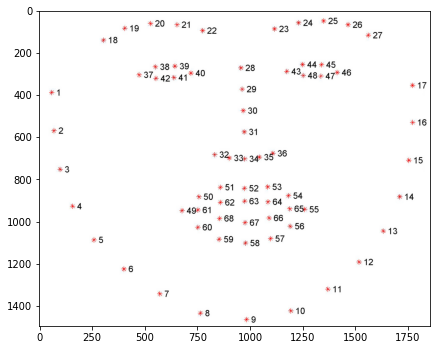

In [4]:
# Plot the facial landmarks
Example=plt.imread(Working_directory + './facial_landmarks_68markup.jpg') # function to read a jpg image
plt.figure(figsize = (7,7)) # Size of the plot
plt.imshow(Example)
plt.show()

We randomly shuffle the data (even if it is not necessary for the TP)

In [5]:
# Shuffle data randomly
indeces=np.arange(N) # Integers from 0 to N-1
np.random.shuffle(indeces)

X=Landmarks[indeces]
Yp=Y[indeces]
Imagesp=Images[indeces]

Namesp=[''] * N
for i in range(0,N):
    Namesp[i]=Names[indeces[i]] 


and we plot the first 6 (random) images with their respective landmarks

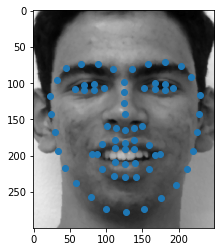

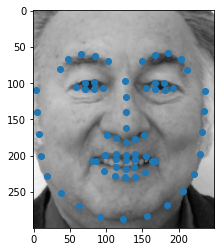

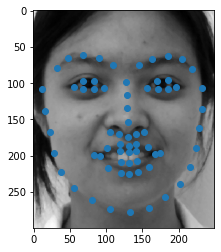

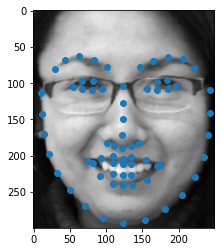

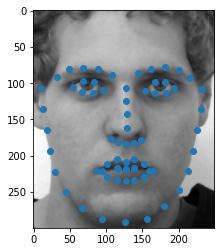

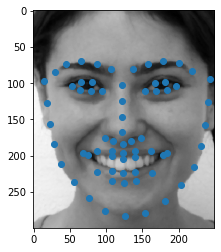

In [6]:
# plot the first 6 images of the data-set
for i in range(0,6):
    image = Imagesp[i,:,:]
    plt.figure()
    plt.imshow(image, cmap='gray', origin='upper')
    landmark=X[i,:]
    x=landmark[::2]
    y=landmark[1::2]
    plt.plot(x,y,'o')
    plt.show()

Now it's time to implement first the affine transformation and then the procrustes alignement (similarity transformation).
Please complete the code.

In [7]:
def AffineRegistrationLandmarks(x,y):
    
    '''
    Inputs: 
               x: [M,2] array containing the M 2-dim source landmarks
               y: [M,2] array containing the M 2-dim target landmarks
    
    Outputs:
               xp: [M,2] array containing the M 2-dim aligned source landmarks
               T: [3,3] transformation matrix
    
    '''

    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')
        
    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')        
        
    M=x.shape[0]
    
    # ## First method
    # # Center data
    # mux=np.mean(x,axis=0)
    # xc=x- mux
    # muy = np.mean(y,axis=0) 
    # yc=y-muy
 
    # A1=np.zeros((2,2))
    # A2=np.zeros((2,2))
    # for i in range(M):
    #     A1=A1+np.outer(yc[i,:],xc[i,:])   #np.dot(yc[i,:].reshape(2,1),xc[i,:].reshape(1,2))
    #     A2=A2+np.outer(xc[i,:],xc[i,:])
     
    # A = np.dot(A1,LA.inv(A2))    
    # t = muy - np.dot(A,mux)
    # xp2 = xc @ A + np.ones((M,1)) @ muy.reshape(1,2)
    
    ## Second method (homogeneous coordinates)
    X=np.zeros((2*M,6))
    X[:M,:2]=x
    X[:M,2]=1
    X[M:2*M,3:5]=x
    X[M:2*M,5]=1
    
    Y=y.T.reshape(2*M,1)
    
    c = LA.solve(np.dot(X.T,X),np.dot(X.T,Y)) #  np.dot(LA.inv(np.dot(X.T,X)),np.dot(X.T,Y))
    XP = np.dot(X,c)
    xp = np.zeros((M,2))
    xp[:,0]=np.ravel(XP[0:M])
    xp[:,1]=np.ravel(XP[M:2*M])
    
    T = np.array([
            [c[0], c[1], c[2]],
            [c[3], c[4], c[5]],
            [0, 0, 1]
            ]).astype('float')
       
    return xp,T


Let's test your implementation and see if it works.

[[ 1.09008733e+00 -1.54379709e-02 -7.13087181e+00]
 [ 5.46148091e-04  1.16407037e+00 -1.93667367e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


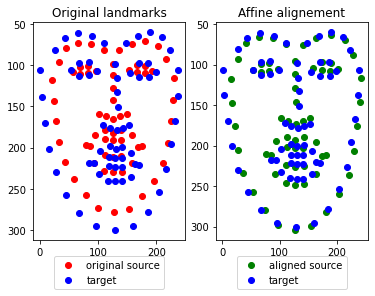

In [8]:
# Choose two random indeces between 0 and N-1
indexSource = 0
indexTarget = 399
# Procrustes superimposition of two configurations    
ls = X[indexSource] # source configuration
Is = Imagesp[indexSource,:,:]
lt = X[indexTarget] # target configuration
It = Imagesp[indexTarget,:,:]

# reshape landmarks configurations as matrices [M,2]
xs=np.reshape(ls,(M,dim))
xt=np.reshape(lt,(M,dim))

xpA,TA=AffineRegistrationLandmarks(xs,xt)
print(TA)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xpA[:,0], xpA[:,1], c='g',label='aligned source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Affine alignement')

Now, let's implement the procrustes alignement following the inputs and rules explained in the header of the function. 

In [9]:
def procrustes_align(x,y,mode='best',verbose=1):

    """ 
    Inputs: 
               X: [M,2] array containing the M 2-dim source landmarks
               Y: [M,2] matrix containing the M 2-dim target landmarks
               mode: 'rotation' to have only rotation, 'reflection' to
                   have only reflection and 'best' to have the one decided by the
                   data depending on det(U*V')
               verbose: 1 to have explanations and 0 otherwise
    
    Outputs:
               Xp: [M,2] array containing the aligned source landmarks
               s: uniform scaling
               R: rotation or reflection matrix
               t: translation vector
               SSR: sum of squared of residuals
               ratio_SSR: ratio of SSR with respect to the initial SSR
    
    """
    
    if mode.lower()!='best' and mode.lower()!='rotation' and mode.lower()!='reflection':
        raise NameError('Error ! mode should be equal to best, rotation or reflection')   
    
    if x.shape[0] != y.shape[0] or x.shape[1] != y.shape[1]:
        raise NameError('data should have the same dimensions')
        
    if x.shape[1] != 2:
        raise NameError('This code works only for 2 dimennsional data')        
        
    M=x.shape[0]
    
    # Center data
    mux=np.mean(x,axis=0)
    xc=x- mux
    muy = np.mean(y,axis=0) 
    yc=y-muy
    # Scale to equal unit size
    SX=np.sqrt(np.sum(np.power(xc,2)))
    xcs=xc/SX
    SY=np.sqrt(np.sum(np.power(yc,2)))
    ycs=yc/SY
        
    # Optimal parameters
    U, D, Vt = np.linalg.svd(np.transpose(xcs)@ycs, full_matrices=True)
    
    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')               
            S=np.eye(2) 
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection but a rotation is computed as requested.')               
            S=np.array([[1, 0], [0, np.linalg.det(U@Vt)]]) # to have det(U*V')=1
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation but a reflection is computed as requested.')               
            S=np.array([[1, 0], [0, -np.linalg.det(U@Vt)]]) # to have det(U*V')=-1
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')               
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
    elif mode.lower() == 'best':
        if np.absolute(np.linalg.det(U @ Vt)-1)<1e-5: # det(R)==1
            if verbose == 1:
                print('The best R is a rotation. Computing rotation.')               
            S=np.eye(2)
        elif np.absolute(np.linalg.det(U @ Vt)+1)<1e-5: # det(R)== -1
            if verbose == 1:
                print('The best R is a reflection. Computing reflection.')               
            S=np.eye(2)
        else:
            raise NameError('Error ! U*Vt should be an orthogonal matrix')
            
    R=U @ S @ Vt
    s=np.trace(S @ np.diag(D))*SY/SX
    
    if mode.lower() == 'rotation':
        if np.absolute(np.linalg.det(R)-1)>1e-5:
            raise NameError('Error ! there is a problem...')
    if mode.lower() == 'reflection':
        if np.absolute(np.linalg.det(R)+1)>1e-5:
            raise NameError('Error ! there is a problem...')
            
    t = muy - s*mux @ R
    xp = s*xc @ R + np.ones((M,1)) @ muy.reshape(1,2)
    
    # Procrustes residuals
    SSR = np.sum(np.power((y-xp),2))
    
    # Ratio with initial residual
    SSR0 = np.sum(np.power((y-x),2))
    ratioSSR = SSR*100/SSR0
    
    return xp, s, R, t, SSR, ratioSSR

Let's test your implementation and see if it works.

The best R is a rotation. Computing rotation.


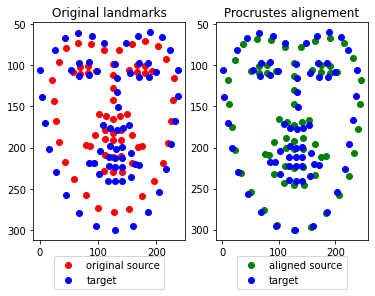

In [10]:
xp, s, R, t, SSR, ratioSSR = procrustes_align(xs,xt)

if show_plot==1:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.scatter(xs[:,0], xs[:,1], c='r',label='original source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Original landmarks')
    plt.subplot(1, 2, 2)
    plt.scatter(xp[:,0], xp[:,1], c='g',label='aligned source') 
    plt.scatter(xt[:,0], xt[:,1], c='b',label='target')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05)) 
    plt.gca().invert_yaxis() 
    plt.title('Procrustes alignement')

**QUESTIONS**

*   What happens if you center the configurations before the alignment ?
*   When do you expect a perfect alignment ?



Now let's implement the Generalized Procrustes Analysis (GPA) using the previously implemented procrustes alignement function.

As before, please follow the inputs and rules explained in the header of the function.

In [11]:

def generalized_procrustes_analysis(X,tau=1e-5,tangent=1):
  """
  Inputs: 
            X: [N,2M] array containing N configurations of 2D landmarks. 
               Each configuration has M landmarks
            tau: parameter for the stopping criteria (please refer to the slides 
                 of the course)
            tangent: if set to 1, data will be projected onto the tangent space

  Outputs: 
            Xm1: [M,2] array containing the landmarks of the average configuration
            Xcp: [N,2M] array containing the aligned landmarks onto Xm1

  """

  if X.shape[1] % 2 != 0:
        raise NameError('This code works only for 2 dimennsional data')        
          
  # Parameters
  N,M=X.shape
  dim=2
  M=int(M/dim)

  # Plot original data
  plt.figure()    
  for i in range(0,N):
      landmark=X[i]
      x=landmark[::2]
      y=landmark[1::2]        
      plt.scatter(x, y, c='r') 
  plt.gca().invert_yaxis()     
  plt.title('Original landmarks')


  # Center each configuration
  Xc=np.zeros((N,M*dim))
  for i in range(0,N):
      t=X[i,:]
      l=np.reshape(t,(M,dim))
      lc=l-np.mean(l,axis=0)        
      Xc[i] = np.reshape(lc,(M*dim))
      
  # Compute first average configuration
  Xm0=np.sum(Xc,axis=0)/N

  # Plot configurations and first average    
  plt.figure()    
  for i in range(0,N):
      landmark=Xc[i]
      x=landmark[::2]
      y=landmark[1::2]        
      plt.scatter(x, y, c='r')       
  plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average')    
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
  plt.gca().invert_yaxis() 
  plt.title('Centered data with first average') 

  # Normalize average
  Xm0=np.reshape(Xm0,(M,dim))
  C=np.eye(M) - ( np.outer(np.ones(M),np.ones(M)) ) / M
  SXm0 = np.sqrt(np.trace(Xm0.T @ C @ Xm0))
  Xm0 = (C @ Xm0)/SXm0

  # Procrustes alignement of all configurations to the average Xm0
  Xcp=np.zeros((N,M*dim))
  for i in range(0,N):
      temp=np.reshape(Xc[i],(M,dim))
      xp, s, R, t, SSR, ratioSSR = procrustes_align(temp,Xm0,'best',0)
      Xcp[i]=np.reshape(xp,(M*dim))
      
  # Reshape average as vector
  Xm0=np.reshape(Xm0,(M*dim))
      
  # Plot configurations and average    
  plt.figure()    
  for i in range(0,N):
      landmark=Xcp[i]
      x=landmark[::2]
      y=landmark[1::2]        
      plt.scatter(x, y, c='r') 
  plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average')  
  plt.gca().invert_yaxis()   
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
  plt.title('Aligned data to normalized initial mean')    

  # Tangent space projection
  if tangent==1:
      # landmarks after tangent space projection
      Xcpt=np.zeros((N,M*dim))
      # vector measuring the difference before/after projection
      diff = np.zeros((N,1))
      
      for i in range(0,N):
          Xcpt[i]=Xcp[i]*((np.dot(Xm0,Xm0)) /(np.dot(Xcp[i],Xm0))) # in our case np.dot(Xm0,Xm0)=1
          diff[i]=np.sum(np.sqrt(np.sum(np.power((np.reshape(Xcpt[i],(M,dim)) - np.reshape(Xcp[i],(M,dim))),2),axis=1))) 
          
      # we look for the subject with the maximum difference before/after projection    
      ind=np.argmax(diff)
          
  #        # Plot configurations and first average
      plt.figure()
      l=Xcp[ind]
      lt=Xcpt[ind]
      plt.scatter(l[::2], l[1::2], c='r', label='before projection')  
      plt.scatter(lt[::2], lt[1::2], c='b', label='after projection') 
      plt.gca().invert_yaxis() 
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
      plt.title('Subject with maximum variation')        

      plt.figure()
      for i in range(0,N):
          landmark=Xcp[i]
          x=landmark[::2]
          y=landmark[1::2]        
          if i==ind:
              plt.scatter(x, y, c='b',label='Subject with max distortion', zorder=10)
          else:
              plt.scatter(x, y, c='r')
              
      plt.scatter(Xm0[::2],Xm0[1::2],c='g',label='average', zorder=5)   
      plt.gca().invert_yaxis()  
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
      plt.title('Subjects before projection')  
      
      Xcp=Xcpt

  # Re-estimate average configuration
  Xm1=np.sum(Xcp,axis=0)/N

  # Procrustes alignement of Xm1 to Xm0 
  Xm1, s, R, t, SSR, ratioSSR = procrustes_align(np.reshape(Xm1,(M,dim)) ,np.reshape(Xm0,(M,dim)),'best',0)

  # Normalize new average Xm1 
  SXm1 = np.sqrt(np.trace(Xm1.T@C@Xm1))
  Xm1 = (C@Xm1)/SXm1

  # Reshape average as vector
  Xm1=np.reshape(Xm1,(M*dim))

  # Plot configurations and new average    
  plt.figure()    
  for i in range(0,N):
      landmark=Xcp[i]
      x=landmark[::2]
      y=landmark[1::2]        
      plt.scatter(x, y, c='r') 
  plt.scatter(Xm1[::2],Xm1[1::2],c='g',label='average')   
  plt.gca().invert_yaxis()  
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
  plt.title('Aligned data to new mean')   


  itera=1    
  while np.sqrt(np.dot((Xm0-Xm1),(Xm0-Xm1))) > tau:
      print('Iter number %d , Error: %f' % (itera, np.sqrt(np.dot((Xm0-Xm1),(Xm0-Xm1))) ) )
      itera=itera+1
      
      # Update Xm0 to Xm1
      Xm0=Xm1
      
      # Procrustes alignement of all configurations to the average Xm0        
      for i in range(0,N):
          temp=np.reshape(Xc[i],(M,dim))
          xp, s, R, t, SSR, ratioSSR = procrustes_align(temp,np.reshape(Xm0,(M,dim)),'best',0)
          Xcp[i]=np.reshape(xp,(M*dim))
          
      # Tangent space projection
      if tangent==1:                  
          for i in range(0,N):
              Xcp[i]=Xcp[i]/(np.dot(Xcp[i],Xm0))                
      
      # Re-estimate average configuration
      Xm1=np.sum(Xcp,axis=0)/N
      
      # Procrustes alignement of Xm1 to Xm0 
      Xm1, s, R, t, SSR, ratioSSR = procrustes_align(np.reshape(Xm1,(M,dim)),np.reshape(Xm0,(M,dim)),'best',0)
      
      # Normalize new average Xm1 
      SXm1 = np.sqrt(np.trace(Xm1.T@C@Xm1))
      Xm1 = (C@Xm1)/SXm1
      
      # Reshape average as vector
      Xm1=np.reshape(Xm1,(M*dim))
      
      # Plot configurations and new average    
      plt.figure()    
      for i in range(0,N):
          landmark=Xcp[i]
          x=landmark[::2]
          y=landmark[1::2]        
          plt.scatter(x, y, c='r') 
      plt.scatter(Xm1[::2],Xm1[1::2],c='g',label='average')  
      plt.gca().invert_yaxis()   
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 
      plt.title('GPA results after iter %i' % itera)
      

  return Xcp, Xm1 


Let's test your implementation and see if it works.

Iter number 1 , Error: 0.000585


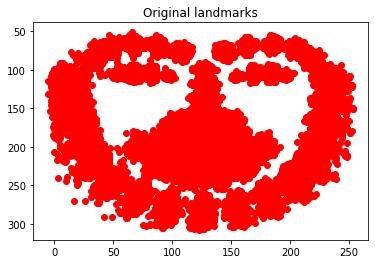

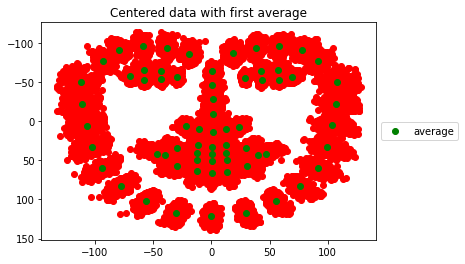

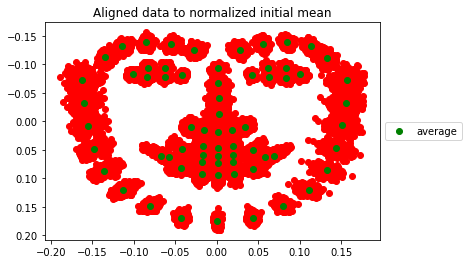

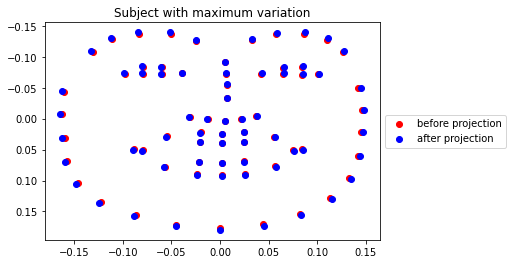

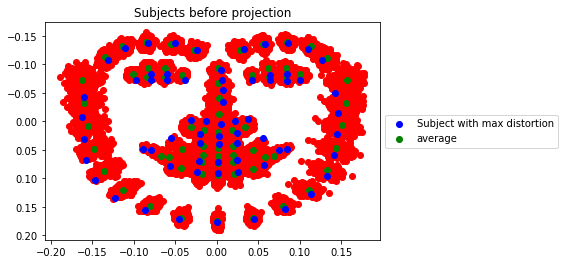

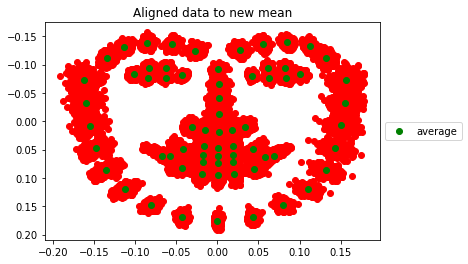

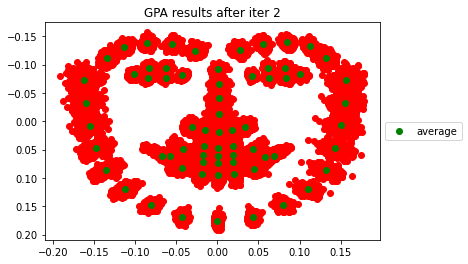

In [12]:
#  GPA (Generalized Procrustes Analysis)
Xcp, Xm1  = generalized_procrustes_analysis(X)   

**QUESTIONS**


*   Try not to project the data onto the tangent space (i.e. `tangent=0`). Do the results vary ? Why in your opinion ? Hint: Look at the variability of the original data...
*   Do the following four triangles have the same shape ? Explain why ?

![shape.png](https://drive.google.com/uc?id=10OSJUfNDJ1xw6H3sRu7l3LRoojxju_4L)



In [13]:
def PCA(X):

  '''
  Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
            column consists of features.

  Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
            
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)

            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
            
            var_explained: percentage of the original variability explained
            by each principal component.
  '''
  N=X.shape[0]
  Xc=X- np.mean(X,axis=0)    
  H, D2, Vt = np.linalg.svd(Xc, full_matrices=True)
  U=Vt.T
  Y=Xc @ U
  D=np.power(D2,2)/(N-1)
  tot=np.sum(D)
  var_explained=D*100/tot

  return Y, U, D, var_explained

The first three modes explain 29.685260, 25.140519 and 12.547151 of the total variability respectively


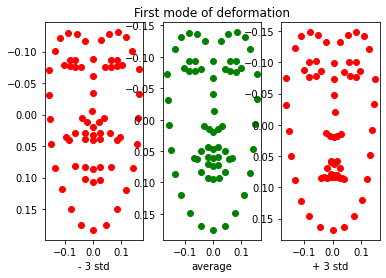

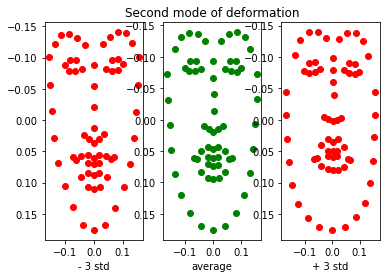

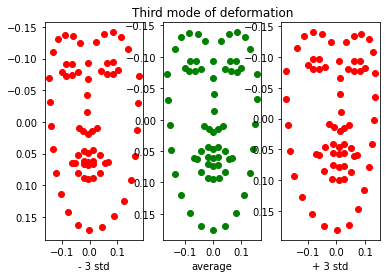

In [16]:
#%% Shape variability analysis

# PCA
Y, U, D, var_explained = PCA(Xcp)

print('The first three modes explain %f, %f and %f of the total variability respectively' % (var_explained[0], var_explained[1], var_explained[2]))

# Compute first mode
first_mode_m= Xm1 - 3 * np.sqrt(D[0]) * U[:,0]
first_mode_p= Xm1 + 3 * np.sqrt(D[0]) * U[:,0]
# Compute second mode
second_mode_m= Xm1 - 3 * np.sqrt(D[1]) * U[:,1]
second_mode_p= Xm1 + 3 * np.sqrt(D[1]) * U[:,1]
# Compute third mode
third_mode_m= Xm1 - 3 * np.sqrt(D[2]) * U[:,2]
third_mode_p= Xm1 + 3 * np.sqrt(D[2]) * U[:,2]

if show_plot==1:
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(first_mode_m[::2], first_mode_m[1::2], c='r') 
    plt.xlabel('- 3 std')
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average') 
    plt.title('First mode of deformation') 
    plt.gca().invert_yaxis()    
    plt.subplot(1, 3, 3)
    plt.scatter(first_mode_p[::2], first_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std') 
    plt.gca().invert_yaxis() 
    
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(second_mode_m[::2], second_mode_m[1::2], c='r') 
    plt.xlabel('- 3 std') 
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average') 
    plt.title('Second mode of deformation')    
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 3)
    plt.scatter(second_mode_p[::2], second_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std') 
    plt.gca().invert_yaxis() 

    plt.figure()
    plt.subplot(1, 3, 1)
    plt.scatter(third_mode_m[::2], third_mode_m[1::2], c='r') 
    plt.xlabel('- 3 std') 
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 2)
    plt.scatter(Xm1[::2], Xm1[1::2], c='g')
    plt.xlabel('average') 
    plt.title('Third mode of deformation')    
    plt.gca().invert_yaxis() 
    plt.subplot(1, 3, 3)
    plt.scatter(third_mode_p[::2], third_mode_p[1::2], c='r')
    plt.xlabel('+ 3 std') 
    plt.gca().invert_yaxis() 


**QUESTIONS**


*   How many modes do you need to explain 90% of the variability ?
*   Which anatomical variability do the first three modes show ? Was it expected ?
*   How could you check whether they show an anatomically plausible deformation ? 
*   Let's say that the anatomical deformation is not anatomically plausible, which kind of deformation would you use instead ? Why ?


